# Lab 6: Azure AI Services

Azure AI services, help developers and organizations rapidly create intelligent, cutting-edge, market-ready, and responsible applications with prebuilt and customizable APIs and models. 

### Exercise overview

In this exercise, you'll learn how to use Azure AI services native endpoints in Fabric to enrich your data with prebuilt AI models without any prerequisite. The scenario is to use SynapseML integration with Azure AI Services to leverage Azure AI Translator and Text Analytics services to perform different tasks such as language translation and sentiment analysis on customer reviews and feedback. Moreover, you will learn how to use SynapseML and LangChain to build an LLM model that categorizes customer reviews and feedback into major themes that influenced customers' decision to leave the bank.

The main steps in this notebook are:

1. Import and Install reuired libraries
2. Load the data and perform exploratory data analysis
3. Use prebuilt Azure AI models in Fabric for translation and sentiment analysis
4. Leverage SynapseML and LangChain to create an LLM model to categorize customer feedback
5. Use SynapseML and OpenAI Chat Completion to perform Q&A on the data

### Helpful links
- [SynapseML in Microsoft Fabric](https://learn.microsoft.com/en-us/fabric/data-science/ai-services/ai-services-overview)

## Step 1: Setup your notebook

### Select Lakehouse

First, add the Lakehouse you created from the prior lab exercise.

<br>

![image-alt-text](https://synapseaisolutionsa.blob.core.windows.net/public/Fabric-Conference/add-lakehouse.png)

## Step 2: Install and import required libraries

Before we move forward with sentiment analysis of customer reviews, it is imperative to first install and import the essential libraries from Spark and SynapseML.

In [ ]:
%pip install openai==0.28.1 | grep -v 'already satisfied'

StatementMeta(, , -1, Finished, Available)


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.



In [ ]:
%pip install openai langchain==0.0.331 | grep -v 'already satisfied'

StatementMeta(, , -1, Finished, Available)


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.



In [ ]:
%pip install wordcloud textblob

StatementMeta(, , -1, Finished, Available)


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.



In [ ]:
#Run this cell to install the required packages for Copilot
%pip install https://aka.ms/chat_magics-0.0.0-py3-none-any.whl
%load_ext chat_magics

In [ ]:
import os, openai, requests, langchain, uuid
from langchain.chat_models import AzureChatOpenAI
from langchain.chains import TransformChain, LLMChain, SimpleSequentialChain
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)

import synapse.ml.core
from synapse.ml.services.language import AnalyzeText
from langchain.schema.messages import HumanMessage, SystemMessage
os.environ['OPENAI_API_VERSION'] = '2023-05-15'
from pyspark.sql.functions import explode, split, col
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pyspark.ml.feature import StopWordsRemover
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from textblob import TextBlob

StatementMeta(, befcec70-e4ea-4551-b73c-7c82a990de41, 109, Finished, Available)

## Step 3: Load and explore the data

In [ ]:
IS_CUSTOM_DATA = False  # if TRUE, dataset has to be uploaded manually

DATA_FOLDER = "Files/customer_feedback"  # folder with data files
DATA_FILE = "customer_feedback.csv"  # data file name

StatementMeta(, befcec70-e4ea-4551-b73c-7c82a990de41, 110, Finished, Available)

In [ ]:
if not IS_CUSTOM_DATA:

    import os, requests
    # Download demo data files into lakehouse if not exist
    remote_url = "https://synapseaisolutionsa.blob.core.windows.net/public/LLM-Demo"
    fname = "customer_feedback.csv"
    download_path = f"/lakehouse/default/{DATA_FOLDER}/raw"

    if not os.path.exists("/lakehouse/default"):
        raise FileNotFoundError("Default lakehouse not found, please add a lakehouse and restart the session.")
    os.makedirs(download_path, exist_ok=True)
    if not os.path.exists(f"{download_path}/{fname}"):
        r = requests.get(f"{remote_url}/{fname}", timeout=30)
        with open(f"{download_path}/{fname}", "wb") as f:
            f.write(r.content)
    print("Downloaded demo data files into lakehouse.")

StatementMeta(, befcec70-e4ea-4551-b73c-7c82a990de41, 111, Finished, Available)

Downloaded demo data files into lakehouse.


In [ ]:
df_spark = (
    spark.read.format("csv")
    .option("header", "true")
    .option("inferSchema", True)
    .load(f"{DATA_FOLDER}/raw/{DATA_FILE}")
    .cache()
)

StatementMeta(, befcec70-e4ea-4551-b73c-7c82a990de41, 112, Finished, Available)

In [ ]:
display(df_spark)

StatementMeta(, befcec70-e4ea-4551-b73c-7c82a990de41, 113, Finished, Available)

SynapseWidget(Synapse.DataFrame, 06104ae0-0a38-46bd-b83e-9208714206e6)

In [ ]:
# List the columns of Spark DataFrame
df_spark.columns

StatementMeta(, befcec70-e4ea-4551-b73c-7c82a990de41, 114, Finished, Available)

['RowNumber',
 'CustomerId',
 'Surname',
 'CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited',
 'CustomerFeedback']

In [ ]:
# Display DataFrame schema
df_spark.printSchema()

StatementMeta(, befcec70-e4ea-4551-b73c-7c82a990de41, 115, Finished, Available)

root
 |-- RowNumber: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)
 |-- CustomerFeedback: string (nullable = true)



#### Word Cloud of most common words

The word cloud of most common words is a visualization technique illustrating the prevalent terms within a text dataset. Initially, the text undergoes preprocessing to remove irrelevant elements such as punctuation and stopwords.
Following this, the frequency of each word is calculated based on its occurrence in the dataset. These words are then visually represented in a cloud-like formation, where larger words indicate higher frequency.
This visualization offers a swift and intuitive insight into the primary themes or topics present in the text data.


StatementMeta(, befcec70-e4ea-4551-b73c-7c82a990de41, 116, Finished, Available)

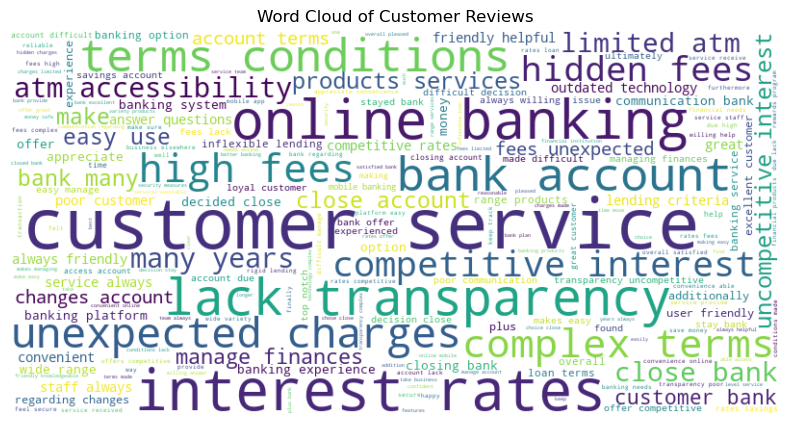

In [ ]:
from pyspark.sql.functions import explode, split, col
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pyspark.ml.feature import StopWordsRemover

reviews_text = " ".join(review['CustomerFeedback'] for review in df_spark.select('CustomerFeedback').collect())

# Convert the reviews text to lowercase
reviews_text_lower = reviews_text.lower()
# Create a list of words
words = reviews_text_lower.split()
# Load English stopwords
stopwords = set(StopWordsRemover().getStopWords())
# Remove stopwords from the list of words
filtered_words = [word for word in words if word not in stopwords]
# Join the filtered words back into a single string
filtered_reviews_text = " ".join(filtered_words)
# Generate WordCloud with stopwords removed
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_reviews_text)

# Plot WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Customer Reviews')
plt.show()



#### Sentiment analysis pie chart 
A Sentiment Analysis Pie Chart is a visual representation of sentiment categories (such as positive, negative, and neutral) derived from analyzing text data. It displays the distribution of sentiments within the dataset, typically using a circular chart where each segment represents a sentiment category and its size reflects the proportion of text data assigned to that sentiment category.

StatementMeta(, befcec70-e4ea-4551-b73c-7c82a990de41, 117, Finished, Available)

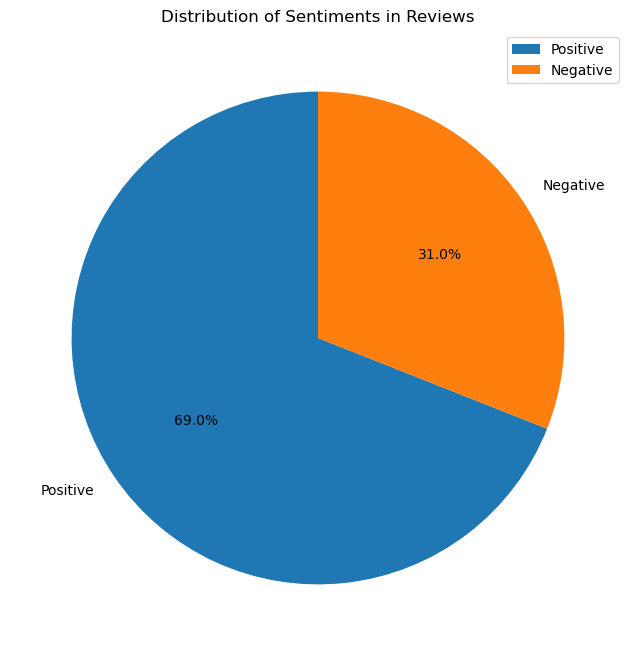

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from textblob import TextBlob

# Define a UDF for sentiment analysis using TextBlob
def get_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Register UDF
sentiment_udf = udf(get_sentiment, StringType())

# Apply sentiment analysis to each review
df_with_sentiment = df_spark.withColumn('sentiment', sentiment_udf('CustomerFeedback'))

# Calculate count of each sentiment category
sentiment_counts = df_with_sentiment.groupBy('sentiment').count()

# Convert to Pandas DataFrame for plotting
sentiment_counts_pd = sentiment_counts.toPandas()

# Plotting
sentiment_counts_pd.plot(kind='pie', y='count', labels=sentiment_counts_pd['sentiment'],
                         autopct='%1.1f%%', startangle=90, figsize=(8, 8))
plt.ylabel('')
plt.title('Distribution of Sentiments in Reviews')
plt.show()


## Step 4: Utilize Azure AI Services in Fabric

Leverage Azure AI services for various tasks including:

- Translate the customer comments and feedback to another language of your choice such as French and German.
- Perform sentiment analysis on customer comments and feedback.

In [ ]:
# Translate to German and French and Spanish
from synapse.ml.services.translate import Translate
from pyspark.sql.functions import col, flatten

translate = (Translate()
    .setTextCol("CustomerFeedback")
    .setToLanguage(["de", "fr", "es"])
    .setOutputCol("translation")
    .setConcurrency(5))

StatementMeta(, befcec70-e4ea-4551-b73c-7c82a990de41, 118, Finished, Available)

In [ ]:
# Perform sentiment analysis
from synapse.ml.services.language import AnalyzeText

sentiment_analysis_model = (
    AnalyzeText()
    .setKind("SentimentAnalysis")
    .setTextCol("CustomerFeedback")
    .setOutputCol("sentiment_analysis")
    .setErrorCol("error")
)

StatementMeta(, befcec70-e4ea-4551-b73c-7c82a990de41, 119, Finished, Available)

### Demonstrate the model performance

Create a small sample of the spark DataFrame to validate the performance.

In [ ]:
# Create a sample DataFrame
df_sample = df_spark.sample(False, 0.2, seed=0).limit(30)
display(df_sample)

StatementMeta(, befcec70-e4ea-4551-b73c-7c82a990de41, 120, Finished, Available)

SynapseWidget(Synapse.DataFrame, 7081427a-3362-4957-8309-701186fbef85)

In [ ]:
# Perform translation and flatten the translation results
df_translation_result = translate.transform(df_sample)\
    .withColumn("translation", explode(col("translation.translations")))
# Extract translated text into separate columns for German, French, and Spanish
df_translation_result = df_translation_result\
    .withColumn("CustomerFeedback_German", col("translation.text").getItem(0))\
    .withColumn("CustomerFeedback_French", col("translation.text").getItem(1))\
    .withColumn("CustomerFeedback_Spanish", col("translation.text").getItem(2))\
    .select("CustomerFeedback", "CustomerFeedback_German", "CustomerFeedback_French", "CustomerFeedback_Spanish")
# Display the original feedback and translations
display(df_translation_result)

StatementMeta(, befcec70-e4ea-4551-b73c-7c82a990de41, 121, Finished, Available)

SynapseWidget(Synapse.DataFrame, 6d6d4389-46b6-489f-b453-d1dd95494032)

In [ ]:
# Perform sentiment analysis
df_sentiment_results = sentiment_analysis_model.transform(df_sample)
# Display the original feedback and the sentiment analysis
display(df_sentiment_results.select("CustomerFeedback", "sentiment_analysis.documents.sentiment"))

StatementMeta(, befcec70-e4ea-4551-b73c-7c82a990de41, 122, Finished, Available)

SynapseWidget(Synapse.DataFrame, 9f62ba3b-c3fe-46bf-88ff-d7db4611f416)

## Step 6: Create the LLM model

Leverage SynapseML and LangChain to initialize a conversational agent that utilizes the specified GPT-3.5 model hosted on Azure to categorize customer feedbacks.

In [ ]:
# Create a DataFrame that shows the customers who have left the bank
df_exited = df_spark.filter(df_spark['Exited'] == 1)
display(df_exited)

StatementMeta(, befcec70-e4ea-4551-b73c-7c82a990de41, 123, Finished, Available)

SynapseWidget(Synapse.DataFrame, 935409fe-d27e-4e04-a254-3851e14fd9bd)

In [ ]:
# Create a sample DataFrame
df_sample_exited = df_exited.sample(False, 0.2, seed=0).limit(30)
display(df_sample_exited)

StatementMeta(, befcec70-e4ea-4551-b73c-7c82a990de41, 124, Finished, Available)

SynapseWidget(Synapse.DataFrame, 149413ae-f665-4ac6-9268-b4992b10111c)

In [ ]:
llm = AzureChatOpenAI(
    deployment_name='gpt-35-turbo',
    model_name='gpt-35-turbo',
    temperature=0.1,
    verbose=False,
)

template = """
    Your job is to summarize reasons by simple phrases why customer closes the bank account.
    Please use all information available in the dataset to determine only two reasons as if this is going to mentioned to the bank manager.
    Provide multiple reasons separated by a comma if multiple reasons are approprate.
    If you are unsure or a reason cannot be determined, say "Unknown".
    Write the reason as a single word or short phrase.
    Examples:
    I recently closed my bank account due to the lack of transparency and uncompetitive interest rates: High interest rates,
    After dealing with increasing fees, hidden charges, and lack of transparency, I made the decision to close my bank account: Hidden bank charges, increasing bank fees """

system_message = SystemMessage(content=template)
human_template= "{text}"
human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)
chat_prompt = ChatPromptTemplate.from_messages([system_message, human_message_prompt])
chain = LLMChain(llm=llm, prompt=chat_prompt)

StatementMeta(, befcec70-e4ea-4551-b73c-7c82a990de41, 125, Finished, Available)

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from synapse.ml.services.langchain import LangchainTransformer

transformer = (
    LangchainTransformer()
    .setInputCol("CustomerFeedback")
    .setOutputCol("Customer_Reason")
    .setChain(chain)
)
display(transformer.transform(df_sample_exited))

StatementMeta(, befcec70-e4ea-4551-b73c-7c82a990de41, 126, Finished, Available)

SynapseWidget(Synapse.DataFrame, 4a694fd6-ba64-4d5b-908e-f21007c717a5)

# Step 7: Perform Q&A on the data

Leverage SynapseML integration with OpenAI Chat Completion API to perform simple Q&A on the data using the specified GPT-3.5 model hosted on Azure.

In [ ]:
import pyspark.sql.functions as F
from synapse.ml.services.openai import OpenAIChatCompletion
from pyspark.sql import Row
from pyspark.sql.types import *

def create_prompt_column(df, prompt, new_col):
    # Parse the template to identify placeholders
    import re
    placeholders = re.findall(r'\{(.*?)\}', prompt)
    # Construct the dynamic expression to replace placeholders with column values
    # Initialize the format expression with the template where placeholders are replaced by "%s"
    format_expr = prompt
    for placeholder in placeholders:
        format_expr = format_expr.replace(f"{{{placeholder}}}", "%s")
    # Prepare the format_string function arguments
    # The column names are injected directly into the expression
    format_args = ", ".join([f"`{col}`" for col in placeholders])
    # Construct the final expression for Spark SQL
    expr_string = f"format_string('{format_expr}', {format_args})"
    # Apply the logic to create a new column
    df = df.withColumn(new_col, F.expr(expr_string))
    return df

StatementMeta(, befcec70-e4ea-4551-b73c-7c82a990de41, 127, Finished, Available)

In [ ]:
def ask_gpt(df, question, new_col, show_errors=False):
    # Instantiate OpenAIChatCompletion object and configure settings
    chat_completion = (
        OpenAIChatCompletion()
        .setDeploymentName("gpt-35-turbo")
        .setMessagesCol("messages")
        .setErrorCol("errors")
        .setOutputCol("chat_completions")
    )
    # Generate prompts for GPT-3.5 based on input DataFrame and question
    prompt_df = create_prompt_column(df, question, "prompt") \
        .withColumn(
            "messages",
            F.array(F.struct(
                F.lit("user").alias("role"),
                F.col("prompt").alias("content"),
                F.lit("user").alias("name"),
            ))
        )
    # Perform chat completion using GPT-3.5 model
    # Extract the completion result and assign it to the new column
    results = (chat_completion
        .transform(prompt_df)
        .withColumn(new_col, F.col("chat_completions.choices").getItem(0).getItem("message").getItem("content"))
        .drop("prompt", "chat_completions", "messages"))
    if show_errors:
        return results
    else:
        return results.drop("errors")

StatementMeta(, befcec70-e4ea-4551-b73c-7c82a990de41, 128, Finished, Available)

### Determine whether a customer feedback is positive or negative 

In [ ]:
df_sample_gpt= ask_gpt(df_sample, "Is this a positive customer feedback: {CustomerFeedback}? Answer just \"true\" or \"false\"", "PositiveCustomerFeedback")
display(df_sample_gpt)

StatementMeta(, befcec70-e4ea-4551-b73c-7c82a990de41, 129, Finished, Available)

SynapseWidget(Synapse.DataFrame, 5e61a31b-1c95-451d-87e5-69c8ed52ba4c)

### Determine whether a customer credit score is good or not 

In [ ]:
df_sample_gpt= ask_gpt(df_sample, "Is this a good credit score: {CreditScore}? Answer just \"true\" or \"false\"", "GoodCreditScore")
display(df_sample_gpt)

StatementMeta(, befcec70-e4ea-4551-b73c-7c82a990de41, 130, Finished, Available)

SynapseWidget(Synapse.DataFrame, 67834cf2-b59a-49f8-92f3-57f4fc524bf4)

## Excercise

You want to understand the average sentiment for different geographies. 

Use the tools you have learned about, e.g., copilot, data wrangler, LLM programming, etc. to help you answer this question.